In [1]:
import os
import random
import time
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import cv2

import numpy as np
import pandas as pd
from tqdm import tqdm

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO
import torchvision
import torchvision.transforms as transforms

import albumentations as A
from albumentations.pytorch import ToTensorV2
# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()
from matplotlib.patches import Patch
import webcolors

import sys
sys.path.append('/opt/ml/segmentation/semantic-segmentation-level2-cv-06/')
from utils import label_accuracy_score, add_hist, class_colormap
from dataset import CustomDataLoader, collate_fn,\
                train_transform, val_transform, test_transform,\
                category_names

In [2]:
plt.rcParams['axes.grid'] = False

In [3]:
root_path  = '../input/data'

In [4]:
def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

In [5]:
# train.json / validation.json / test.json 디렉토리 설정
train_path = root_path + '/train.json'
val_path = root_path + '/val.json'
test_path = root_path + '/test.json'
batch_size = 32

train_dataset = CustomDataLoader(data_dir=train_path, mode='train', transform=train_transform)
#val_dataset = CustomDataLoader(data_dir=val_path, mode='val', transform=val_transform)
#test_dataset = CustomDataLoader(data_dir=test_path, mode='test', transform=test_transform)

# DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size,
                                           shuffle=False,
                                           num_workers=4,
                                           collate_fn=collate_fn)

# val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
#                                          batch_size=batch_size,
#                                          shuffle=False,
#                                          num_workers=4,
#                                          collate_fn=collate_fn)

# test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
#                                           batch_size=batch_size,
#                                           num_workers=4,
#                                           collate_fn=collate_fn)

loading annotations into memory...
Done (t=3.62s)
creating index...
index created!
/opt/ml/segmentation/semantic-segmentation-level2-cv-06/input/data/train.json
/opt/ml/segmentation/semantic-segmentation-level2-cv-06/input/data


In [6]:
for i, (imgs, masks, image_infos) in enumerate(train_loader):
    #print(len(imgs))
    if i == 0:
        break

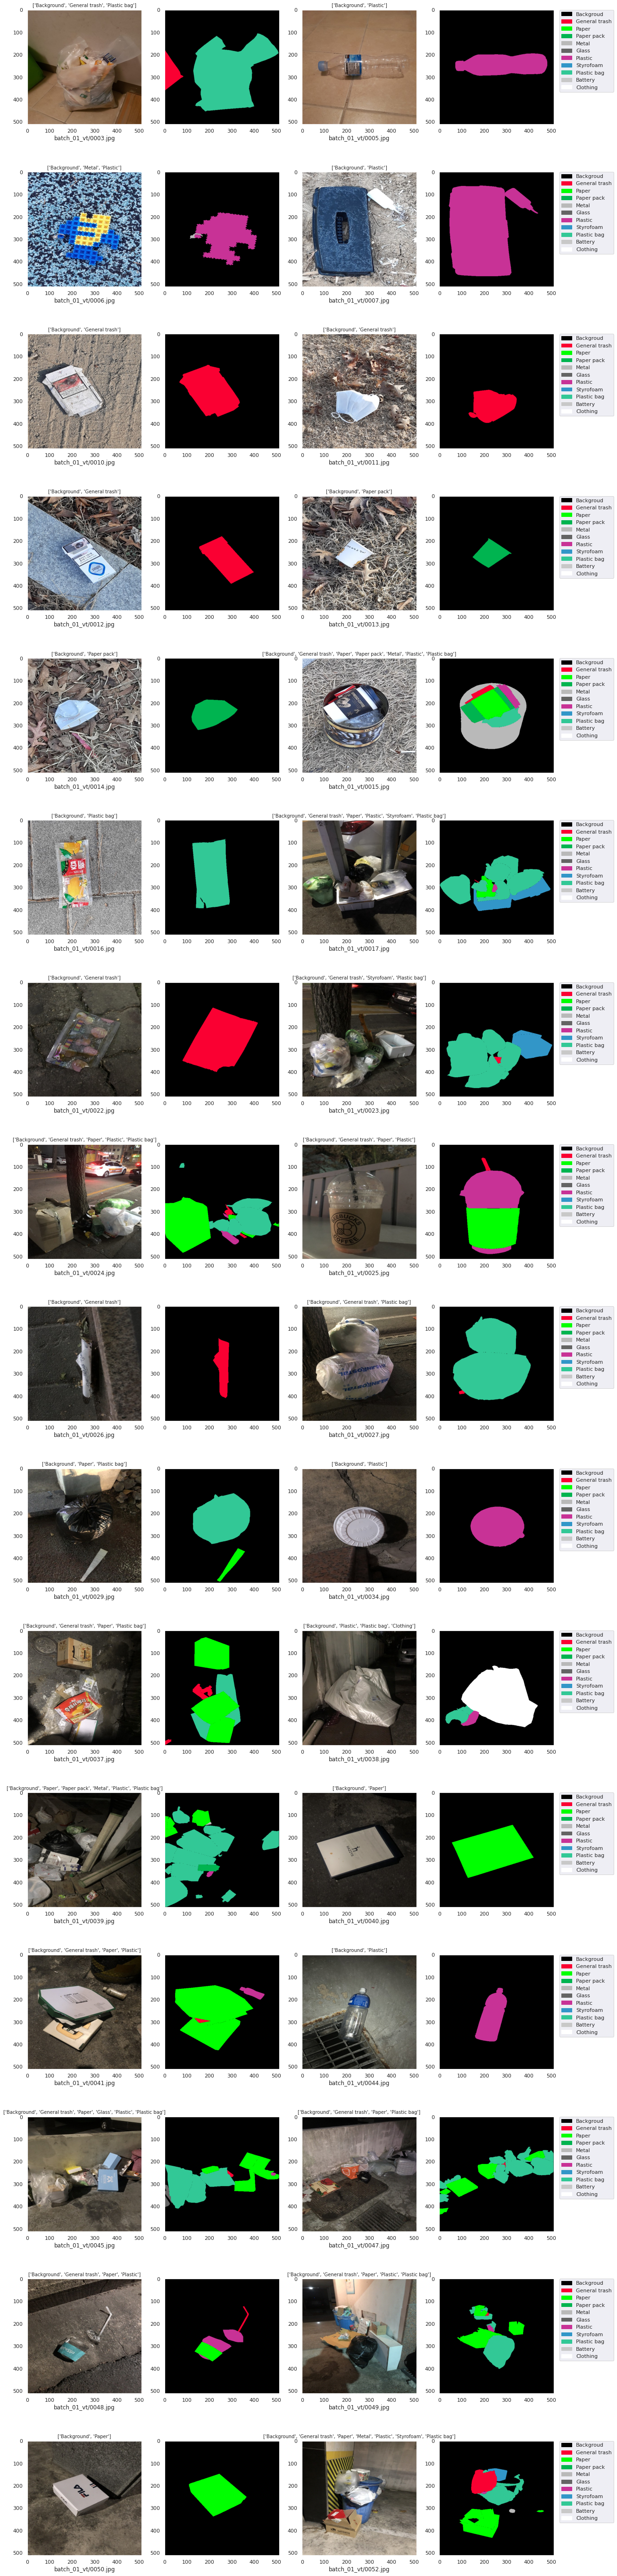

In [7]:
category_and_rgb = [[category, (r,g,b)] for idx, (category, r, g, b) in enumerate(class_colormap.values)]
legend_elements = [Patch(facecolor=webcolors.rgb_to_hex(rgb), 
                         edgecolor=webcolors.rgb_to_hex(rgb), 
                         label=category) for category, rgb in category_and_rgb]

fig, ax = plt.subplots(nrows=16, ncols=4, figsize=(20, 100))
# train_loader의 output 결과(image 및 mask) 확인
for i in range(len(imgs)):
    temp_image_infos = image_infos[i]
    temp_images = imgs[i]
    temp_masks = masks[i]
    
    ax[int(i//2),0 + (i%2)*2].imshow(temp_images.permute([1,2,0]))
    ax[int(i//2),0 + (i%2)*2].grid(False)
    ax[int(i//2),0 + (i%2)*2].set_title("{}".format([category_names[int(i)] for i in list(np.unique(temp_masks))]), fontsize = 10)
    ax[int(i//2),0 + (i%2)*2].set_xlabel(temp_image_infos['file_name'])

    ax[int(i//2),1 + (i%2)*2].imshow(label_to_color_image(temp_masks.detach().cpu().numpy()))
    ax[int(i//2),1 + (i%2)*2].grid(False)
    #ax[int(i//2),1 + (i%2)*2].set_title("{}".format([{int(i),category_names[int(i)]} for i in list(np.unique(temp_masks))], fontsize = 5))
    if (i%2)*2 == 2:
        ax[int(i//2),1 + (i%2)*2].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
    
plt.show()